## Homework 4: A plague of sandmice
### MCB112: Biological Data Analysis
#### Hailey Cambra

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 1. Testing Moriarty's Method 

In [2]:
def Moriarty_score(seq_list):
    '''
    Take in a list of sequences and score them according to Moriarty's method. 
    
    Parameters
    ----------
    seq_list: list
        list of nucleotide sequences
        
    Returns
    -------
    score_list: list
        list of scores for each sequence
    
    '''
    #initialize list for scores for each sequence
    score_list = []
    for seq in seq_list:
        #initialize score to zero so that we start from scratch for each new sequence
        score = 0
        #iterate through the nucleotides of each sequence
        for i in seq:
            #adjust score for each nucleotide
            if i == 'A' or i == "T":
                score = score + 1
            else:
                score = score - 1
        #append final score and start at beginning of for loop again for the next sequence
        score_list.append(score)

    return score_list  

### Read in fasta files and obtain sequences 

In [3]:
#read in the fasta files, sm for sandmouse
mice_seqs = []
mice_ids = []
with open("sandmouse.fa") as sm:
    for line in sm:
        if line.startswith(">"):
            mice_ids.append(line.strip())
        else:
            mice_seqs.append(line.strip())

In [4]:
#repeat for pathogen file, pa for pathogen
path_seqs = []
path_ids = []
with open("pathogen.fa") as pa:
    for line in pa:
        if line.startswith(">"):
            path_ids.append(line.strip())
        else:
            path_seqs.append(line.strip())         

In [5]:
#repeat for Moriarty's negative data to compare later, rn for random
rand_seqs = []
rand_ids = []
with open("moriarty-neg.fa") as rn:
    for line in rn:
        if line.startswith(">"):
            rand_ids.append(line.strip())
        else:
            rand_seqs.append(line.strip())   

### Apply Moriarty's Method 

In [6]:
#get scores for pathogen sequences and mice sequences
path_score_list = Moriarty_score(path_seqs)
mice_score_list = Moriarty_score(mice_seqs)
rand_score_list = Moriarty_score(rand_seqs)

In [7]:
#turn each of the score lists into arrays so that I can plot the scores
path_array = np.array(path_score_list)
mice_array = np.array(mice_score_list)
rand_array = np.array(rand_score_list)

Text(0,0.5,'frequency')

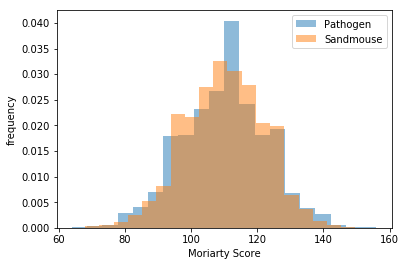

In [8]:
#plot the scores of the pathogen sequences and the mice sequences to see if they look like Moriarty's data
plt.hist(path_array, alpha=0.5, bins=20, density=True, label='Pathogen')
plt.hist(mice_array, alpha=0.5, bins=20, density=True, label='Sandmouse')
plt.legend()
plt.xlabel('Moriarty Score')
plt.ylabel('frequency')

In [9]:
#Get true positive (TP), false positive (FP), true negative (TN), and false negative (FN) score lists for the datasets

#combine scores together so you can define the range of scores to choose over
all_scores = path_array, mice_array

#make an array of scores to choose from to choose a threshold score for the different positive and negative rates
scores = np.arange(np.min(all_scores), np.max(all_scores), 0.1)

TPR = []
FPR = []


#get each of true positives, negatives, etc. and calculate the TPR and FPR, keep going until we have a list of 
#these for various threshold scores
for score in scores:
    TP = (path_array > score).sum()
    FP = (mice_array > score).sum()
    FN = (path_array <= score).sum()
    TN = (mice_array <= score).sum()
    TPR.append(TP/(TP+FN))
    FPR.append(1-(TN/(TN+FP)))
       

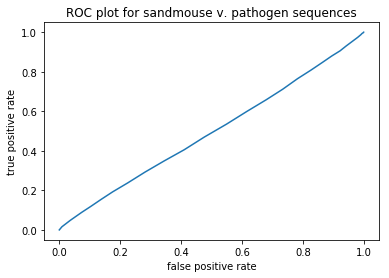

In [10]:
#Make a ROC plot
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC plot for sandmouse v. pathogen sequences')
plt.plot(FPR, TPR)

The pathogen and sandmouse data are overlapping. These results are likely different from Moriarty's because he is comparing to random sequences, instead of an actual dataset that serves as a control for the pathogenic mice sequences. The ROC plot I have plotted shows a linear relationship between the false and true positive rates, which means we really aren't distinguishing between the pathogen sequences and the sandmouse sequences with his method. What he has done is choose a meaningless negative control for his sample set, and what he is really asking is whether or not he can distinguish a pathogen sequence from a random sequence, not a sandmouse sequence, which is what he is trying to conclude. To drive the point home about comparing to a random set of sequences, I have plotted the 'negative' set that Moriarty used with the pathogen and sandmouse sequences below. 

Text(0,0.5,'frequency')

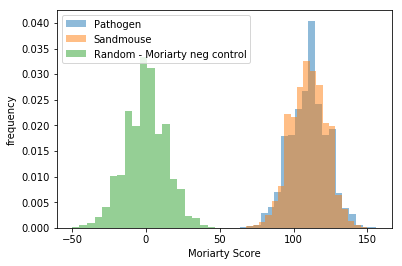

In [11]:
#plot the scores of the pathogen sequences and the mice sequences to see if they look like Moriarty's data
plt.hist(path_array, alpha=0.5, bins=20, density=True, label='Pathogen')
plt.hist(mice_array, alpha=0.5, bins=20, density=True, label='Sandmouse')
plt.hist(rand_array, alpha=0.5, bins=20, density=True, label='Random - Moriarty neg control')
plt.legend()
plt.xlabel('Moriarty Score')
plt.ylabel('frequency')

## 2. Making my own method 

In [12]:
def count_probs(seq_list):
    '''
    Takes in a list of nucleotide sequences, calculates the probability of observing a given nucleotide dimer 
    (dimer probs) and the conditional probability of observing a third nucleotide in the next position to a given 
    dinucleotide.
    
    Parameters
    ----------
    seq_list: list
        list of DNA nucelotide (no 'U') sequences from a dataset 
    
    Returns
    -------
    cond_probs: numpy array
        contains the conditional probability of observing a nt (from third nt list) in position i given the 
        dinculeotide sequence in positions i-1 and i-2
    
    dimer_probs: numpy array
        contains the probability of observing a given dimer sequence from the list of sequences given
    
    '''
    counts_array = np.zeros((16,4), dtype=int)

    #initialize list of dimers and list of the third nt to populate the counts_array later
    dimers_list = ["AA", "AC", "AG", "AT", "CA", "CC", "CG", "CT", "GA", "GC", "GG", "GT", "TA", "TC", "TG", "TT"]
    third_nt = ["A", "C", "G", "T"]


    for seq in seq_list:
        for i in range(len(seq)-2):
            dimer = seq[i:i+2]
            counts_row = dimers_list.index(dimer)
            third = seq[i+2]
            counts_col = third_nt.index(third)
            counts_array[counts_row, counts_col] +=1
    
    #add the last di-nt
    dimer_counts = counts_array.sum(axis=1)

    for seq in seq_list:
        last_dimer = seq[-2:]
        ind_last = dimers_list.index(last_dimer)
        dimer_counts[ind_last] +=1
    
    #define normalization outside for loop
    z = dimer_counts.sum()
    #normalize each element in dimer_counts to get the dimer probabilities - joint probability of nt1 and nt2
    dimer_probs = np.array([i/z for i in dimer_counts])
    
    cond_probs = []

    for row in counts_array:
        #need to reset z for each row
        z = row.sum()
        row_probs = np.array([i/z for i in row])
        cond_probs.append(row_probs)

    cond_probs = np.array(cond_probs)
    
    return cond_probs, dimer_probs

In [13]:
#Train my models for the sandmouse model and the pathogen model, taking the first 5000 sequences to train
mice_cond_probs, mice_dimer_probs = count_probs(mice_seqs[:5000])
path_cond_probs, path_dimer_probs = count_probs(path_seqs[:5000])

In [14]:
def Markov(seq_list, mice_dimer_probs, mice_cond_probs, path_dimer_probs, path_cond_probs):
    
    '''
    Takes in a sequence list and the trained model parameters (conditional and dimer probabilities for 
    each dataset) and returns the log odds ratio score for each sequence in a list.
    
    Parameters
    ----------
    
    seq_list: list
        list of sequences from a given dataset (needs to be different than the sequences used to train!!)
    
    mice_dimer_probs: numpy array
        numpy array containing the dimer probabilities (joint) calculated from the sandmouse data training set.
    
    mice_cond_probs: numpy array
        numpy array containing the conditional probabilities of observing a given nucleotide in the sandmouse data, 
        given the dinucelotide sequence preceding it in the sequence. 
    
    path_dimer_probs: numpy array
        numpy array containing the dimer probabilities (joint) calculated from the pathogen data training set.
    
    path_cond_probs: numpy array
        numpy array containing the conditional probabilities of observing a given nucleotide in the pathogen data, 
        given the dinucelotide sequence preceding it in the sequence. 
        
    Returns
    -------
    
    log_odds: list
        list of log odds ratio of the probability of observing a given sequence, given it may be a pathogen sequence
        over the probability of observing a given sequence, given it may be from the sandmouse data. 
    
    '''
    
    dimers_list = ["AA", "AC", "AG", "AT", "CA", "CC", "CG", "CT", "GA", "GC", "GG", "GT", "TA", "TC", "TG", "TT"]
    third_nt = ["A", "C", "G", "T"]

    log_odds = []
    for seq in seq_list:
        #look at first dinucleotide, because this is our starting point
        #look up dimer probability for the matching dinucleotide sequence from the pathogen training set
        #need to use log for probabilities because they will become very small and python turns really small floats into zeroes

        dind = dimers_list.index(seq[:2])
        m_prob = np.log(mice_dimer_probs[dind])
        p_prob = np.log(path_dimer_probs[dind])
        for i in range(2, len(seq)):
            #look up two previous nts from position i in the sequence in dimers list
            row_ind = dimers_list.index(seq[i-2:i])
            #look up the current nucleotide in the list for third nts
            col_ind = third_nt.index(seq[i])
            #look up the conditional probabilities for each of the models
            m_cond = np.log(mice_cond_probs[row_ind, col_ind])
            p_cond = np.log(path_cond_probs[row_ind, col_ind])

            #update running probabilities of the sequence, adding because we are in logspace
            m_prob = m_prob + m_cond
            p_prob = p_prob + p_cond
        
        #take log odds ratio (subtract because logspace) for each sequence and append to list 
        log_odds.append(p_prob - m_prob)
    
    return log_odds

In [15]:
log_odds_path = Markov(path_seqs[5000:], mice_dimer_probs, mice_cond_probs, path_dimer_probs, path_cond_probs)

In [16]:
log_odds_mice = Markov(mice_seqs[5000:], mice_dimer_probs, mice_cond_probs, path_dimer_probs, path_cond_probs)

Text(0.5,1,'2nd order Markov Model Log Odds Scores')

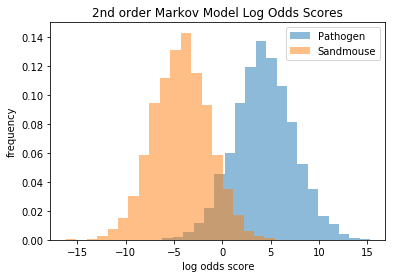

In [17]:
plt.hist(log_odds_path, alpha=0.5, bins=20, density=True, label='Pathogen')
plt.hist(log_odds_mice, alpha=0.5, bins=20, density=True, label='Sandmouse')
plt.legend()
plt.xlabel('log odds score')
plt.ylabel('frequency')
plt.title('2nd order Markov Model Log Odds Scores')

In [18]:
#Get true positive (TP), false positive (FP), true negative (TN), and false negative (FN) score lists for the datasets
#Also get FDR and account for fraction of sequences from each mouse and pathogen population 

#combine scores together so you can define the range of scores to choose over
all_logscores = log_odds_path, log_odds_mice

#make an array of scores to choose from to choose a threshold score for the different positive and negative rates
scores = np.arange(np.min(all_logscores), np.max(all_logscores), 0.01)

#initialize lists, set fractions of sequence reads for use in calculating FDR - could use the fractions for other 
#rates for others, but would end up by multiplying by 1 in the end

TPR = []
FPR = []
FDR = []
frac_path = 0.01
frac_mouse = 0.99

#testing other possible fractions
FDR_f1 = []
frac_path_f1 = 0.99
frac_mouse_f1 = 0.01

FDR_f2 = []
frac_path_f2 = 0.5
frac_mouse_f2 = 0.5

#get each of true positives, negatives, etc. and calculate the TPR and FPR, keep going until we have a list of 
#these for various threshold scores
for score in scores:
    TP = (log_odds_path > score).sum()
    FP = (log_odds_mice > score).sum()
    FN = (log_odds_path <= score).sum()
    TN = (log_odds_mice <= score).sum()
    TPR.append(TP/(TP+FN))
    FPR.append(1-(TN/(TN+FP)))
    FDR.append((FP*frac_mouse)/(TP*frac_path+FP*frac_mouse))
    FDR_f1.append((FP*frac_mouse_f1)/(TP*frac_path_f1+FP*frac_mouse_f1))
    FDR_f2.append((FP*frac_mouse_f2)/(TP*frac_path_f2+FP*frac_mouse_f2))

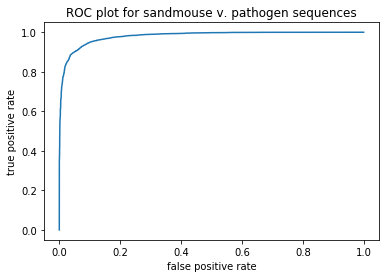

In [19]:
#Make a ROC plot
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC plot for sandmouse v. pathogen sequences')
plt.plot(FPR, TPR)

## 3. How good is my method? 

In [20]:
#iterate through the TPR scores and find which score corresponds to that threshold TPR value
i = 0
while TPR[i] >= 0.9:
    i +=1
#get log odds threshold score for TPR before sensitivity dips below 90%    
print("", "true positive rate:", TPR[i], "\n","false positive rate:", FPR[i], "\n","score threshold needed to set:", scores[i])

 true positive rate: 0.8994 
 false positive rate: 0.048799999999999955 
 score threshold needed to set: 0.43640278542170563


In [21]:
#how much of what I am calling a pathogen is actually not a pathogen
print("False Discovery Rate at TPR threshold:", FDR[i])

False Discovery Rate at TPR threshold: 0.8430530834467596


The fact that our false discovery rate is so high is alarming. I am plotting this below. 

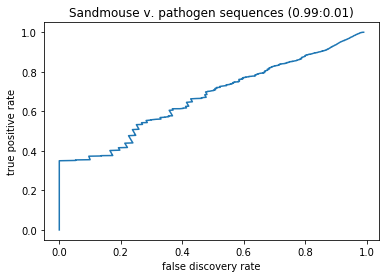

In [22]:
#Make modified 'ROC' plot
plt.xlabel('false discovery rate')
plt.ylabel('true positive rate')
plt.title('Sandmouse v. pathogen sequences (0.99:0.01)')
plt.plot(FDR, TPR)

Looking at the FDR allows us to account for the actual constitution of the sequence population. Because there are so many more sandmouse sequences (99% of reads) than there are pathogenic sequences (1% of reads), the false discovery rate is fairly high. We should sample more of the pathogenic reads to be able come to a conclusion that we can actually trust with our current method, even though the ROC plot looks like we are doing a great job at distinguishing what is a pathogenic sequence from a sandmouse sequence. In the end, the method is good, but we need to sample many more pathogenic sequences to trust the analysis. To drive home this point, I have made a couple of graphs below, to illustrate the effect of the fraction of sequence reads from each population on this analysis. 

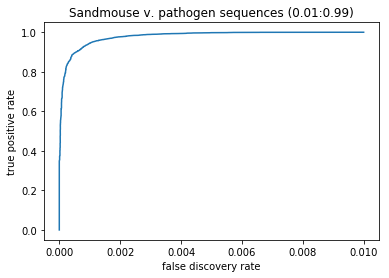

In [23]:
#Make modified 'ROC' plot with different fractions of sequences from each population, here, reversing the fractions
plt.xlabel('false discovery rate')
plt.ylabel('true positive rate')
plt.title('Sandmouse v. pathogen sequences (0.01:0.99)')
plt.plot(FDR_f1, TPR)

We can see that when we alter the fractions of sequences that come from the sandmouse versus pathogen sequences we can obtain a plot with the false discovery rate that looks like our ROC plot with false positive rates. It appears that the more data we can have from the pathogen sequence set, the better we are at classifying an actual pathogen sequence as a pathogen. If we were trying to classify a sandmouse sequence from the pathogen sequence with the fractions reversed, as I have done with FDR_f1, then we would likely suffer from the same problem as we do with our current method and data percentages from each population when we try to classify a pathogen from the sandmouse population. However, since we are trying to classify a pathogen from a sandmouse sequence, having a high percentage of sequences available in the pathogen population helps us to have a much better false discovery rate. Note the very small fractions on the x-axis of this plot above. 

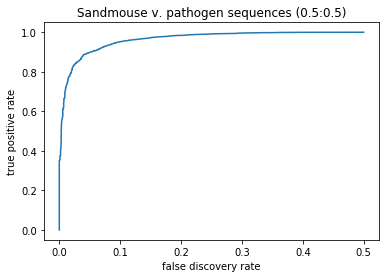

In [24]:
#Make modified 'ROC' plot with different fractions of sequences from each population, here, setting them equal
plt.xlabel('false discovery rate')
plt.ylabel('true positive rate')
plt.title('Sandmouse v. pathogen sequences (0.5:0.5)')
plt.plot(FDR_f2, TPR)

It seems like a fair analysis would include a fairly equal fraction of sequences from each population, so that the classifier can distinguish between what is a pathogen and what is a sandmouse without having to "bias" the classifier in either way by having such a small fraction of either set of sequences represented. 